In [50]:
import numpy as np
import random
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from tqdm import tqdm

seed_value = 42

# Data

In [51]:
def get_data(n, lasso_penality):

    X, y = np.random.randn(n,n), np.random.randn(n)
    Q, p = 1/2 * np.eye(n), y
    b = lasso_penality * np.ones(2*n)
    A = np.ones((2*n,n))
    A[:n] = X.T
    A[n:] = -X.T    

    return X, y, Q, p, b, A


In [100]:
#set the hyperparameters

eps = 1e-6
mu = 2
alpha = 0.5 
beta = 0.9
n = 50
lasso_penality = 10 

In [101]:
# Generate the data 
np.random.seed(seed_value)
random.seed(seed_value)

X, y, Q, p, b, A = get_data(n, lasso_penality)
v0 = np.zeros(n)
print("v0 is feasible: ", (np.dot(A,v0) - b).all())

v0 is feasible:  True


# Functions

In [55]:
# utils

def f(v,Q,p,A,b,t):

    barrier = np.dot(A,v) - b
    if (barrier > 0).any():
        return np.nan
    return t * (np.dot(v, np.dot(Q,v)) + np.dot(p, v)) - np.sum(np.log(-barrier))

def grad_(v,Q,p,A,b,t,barrier):
    return t * (2 * np.dot(Q,v) + p) - np.sum(A * barrier[:, np.newaxis], axis = 0)

def hessian_(v,Q,p,A,b,t,barrier):
    barrier2 = barrier ** 2
    return t * 2 * Q - np.einsum('ij,j,jk->ik', -A.T, barrier2, A)


In [102]:
def linesearch(v,Q,p,A,b,t,grad,direction,alpha=alpha,beta=beta):

    step = 1 #start t=1 
    f_v, v_next = f(v,Q,p,A,b,t), v + step * direction
    value = alpha * np.dot(grad, direction)
    barrier, f_next = np.dot(A,v_next) - b, f(v_next,Q,p,A,b,t)

    while f_next >= f_v + step * value or (barrier > 0).any():
        
        step *= beta
        v_next = v + step * direction
        barrier, f_next = np.dot(A,v_next) - b, f(v_next,Q,p,A,b,t)
        
    return step

In [103]:
def centering_step(Q,p,A,b,t,v0,eps, alpha, n_iter_barr): 

    '''
    Implementation of Newton Method 
    '''
    v, list_v, n_iter = v0.copy(), [v0.copy()], 0
    while True:
        #print("Newton iteration: ", n_iter)
        barrier = 1 / (np.dot(A,v) - b)
        grad = grad_(v,Q,p,A,b,t,barrier)
        hessian = hessian_(v,Q,p,A,b,t,barrier)

        direction = -np.linalg.pinv(hessian).dot(grad)
        lambd = -np.dot(grad.T, direction)

        if (lambd / 2) <= eps: break

        ### line search 
        step= linesearch(v,Q,p,A,b,t,grad,direction,alpha,beta=beta)     
        v += step * direction #update
        list_v.append(v)
        n_iter += 1
    
    return n_iter, list_v #get the last v by list_v[-1]

In [104]:
def barr_method(Q,p,A,b,v0,eps, mu, alpha, t0):

    list_optimals, n_iter_barr = [], 0
    v, t = v0.copy(), t0
    dic = {}

    while 2*Q.shape[0] / t >= eps:

        #print('Iteration barrier method: ', n_iter_barr)
        n_iter, v = centering_step(Q,p,A,b,t,v,eps, alpha, n_iter_barr)[0], centering_step(Q,p,A,b,t,v,eps, alpha, n_iter_barr)[1][-1]  
        list_optimals.append(v.copy())
        dual_gap = (2*Q.shape[0]) / t
        if t == t0:
            dic[dual_gap] = n_iter
        else:
            dic[dual_gap] = n_iter + list(dic.values())[-1]
        t = t * mu
        n_iter_barr += 1

    return list_optimals, dic 


# Resolution

In [105]:
optimals = barr_method(Q,p,A,b,v0,eps, mu, t0 = 1, alpha = alpha)

In [106]:
vf = optimals[0][-1]
print(((A @ vf - b) > 0).any(), vf @ Q @ vf + p @ vf)

False -29.56714073986613


## Comparison with scipy 

In [61]:
from scipy.optimize import minimize

# Objective function: 1/2 * x^T * P * x + q^T * x


# Inequality constraint: G * x <= h

# Bounds: lb <= x <= ub
bounds = ((-5, 5), (-5, 5))

# Solve the QP problem
result = minimize(
    fun=lambda x: x @ Q @ x + p @ x,
    x0=v0,
    jac = lambda x: 2 * Q @ x + p,
    method='SLSQP',
    constraints={'type': 'ineq', 'fun': lambda x: -(A @ x - b)})

# Print the result
print(result)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -29.567140856849466
       x: [-5.274e-01 -7.934e-01 ... -9.504e-01 -1.661e+00]
     nit: 2
     jac: [ 4.316e-02  1.747e-01 ...  7.095e-02  4.270e-01]
    nfev: 2
    njev: 2


<span style="color:red">We found the same result for our optimization problem when using Scipy.</span>


# Question 3

In [84]:
def f0(v,Q,p):
    return np.dot(v, np.dot(Q,v)) + np.dot(p, v)

In [85]:
eps = [0.1**i for i in range(1, 7)]
mus = [2, 15, 50, 100, 200]
dic = {}
for mu_ in tqdm(mus):

    list_vf = []
    for ep in tqdm(eps):
        list_vf.append(barr_method(Q,p,A,b,v0,ep, mu = mu_, t0 = 1, alpha = alpha)[0][-1])
    dic[mu_] = list_vf

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


In [86]:
values = {}
best_value = 0 
for mu_ in mus:
    for v in dic[mu_]:
        if f0(v, Q, p) < best_value:
            best_value = f0(v, Q, p)
    
for mu_ in mus:
    values[mu_] = [f0(v, Q, p) - best_value for v in dic[mu_]]

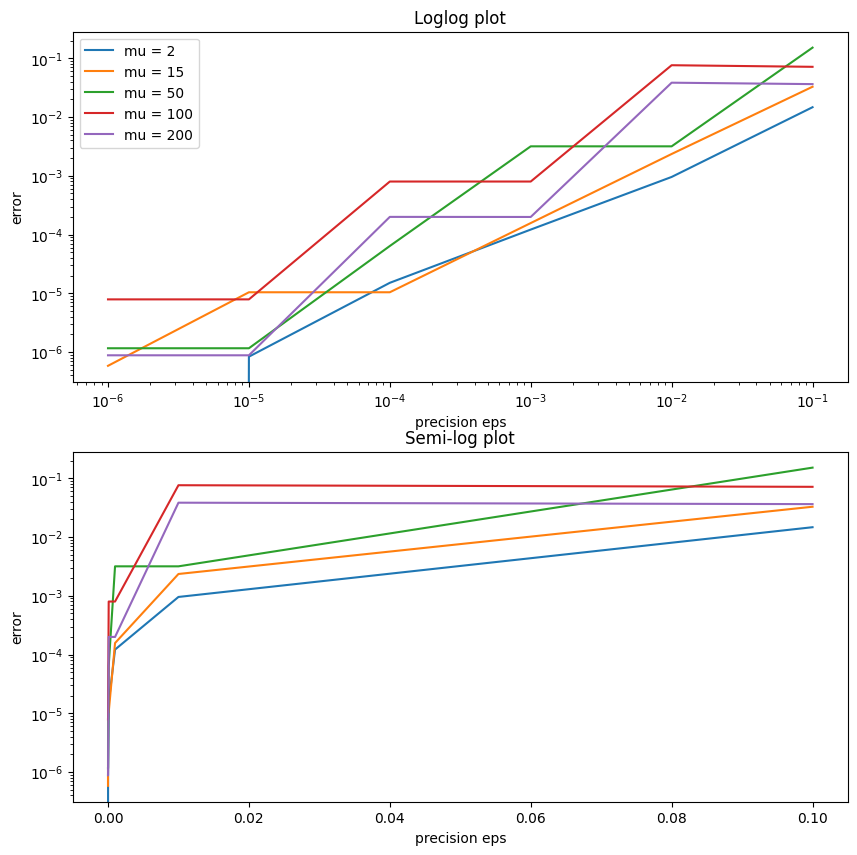

In [87]:
fig, axs = plt.subplots(2, figsize = (10,10))
for mu_ in mus:
    axs[0].loglog(eps, values[mu_], label = f'mu = {mu_}')
    axs[0].set_title('Loglog plot')
    axs[0].set_xlabel('precision eps')
    axs[0].set_ylabel('error')
    axs[1].semilogy(eps, values[mu_], label = f'mu = {mu_}')
    axs[1].set_title('Semi-log plot')
    axs[1].set_xlabel('precision eps')
    axs[1].set_ylabel('error')
axs[0].legend()

### Influence on w

In [91]:
vf = dic[2][-1]
for mu in mus[1:]:
    vf2 = dic[mu][-1]
    print('Cosine similarity: ',(np.dot(vf,vf2)) / np.sqrt(np.sum(vf**2) * np.sum(vf2 ** 2)))

Cosine similarity:  0.9999999999999849
Cosine similarity:  0.9999999999999397
Cosine similarity:  0.9999999999972089
Cosine similarity:  0.999999999999965


<span style="color:red">No matter the value of mu, the solution we obtain for our problem is the same. Hence, mu has no influence on the optimal solution w</span>


In [77]:
mus = [2, 15, 50, 100, 200]
eps = 1e-6
dic = {}
for mu_ in mus:
    dic[mu_] = barr_method(Q,p,A,b,v0,eps, mu = mu_, t0 = 1, alpha = alpha)[1]

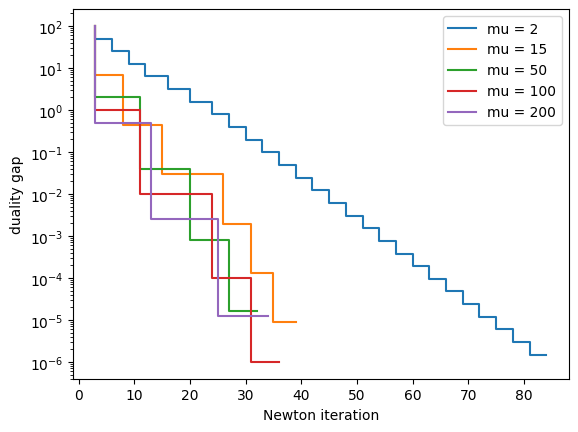

In [80]:
for mu_ in mus:
    dual_gaps, iterations = list(dic[mu_].keys()), list(dic[mu_].values())
    plt.semilogy(iterations, dual_gaps, label = f'mu = {mu_}', drawstyle='steps')
    #plt.step(iterations, dual_gaps)
plt.ylabel('duality gap')
plt.xlabel('Newton iteration')
plt.legend()

<span style="color:red">We see that an for a value of 2, we obtain the best minimization for our problem. However, we can see on the graph above that solving for mu=2 requires a lot of newton iteration. Since we find a solution close to the optimal for mu=50, we can pick a mu around this value to compute fast a good approximation of the optimal.</span>


# Observation in 2D

In [92]:
#set the hyperparameters

eps = 1e-6
mu = 2
alpha = 0.5 
beta = 0.9
n = 2
lasso_penality = 10 

# Generate the data 
np.random.seed(42)
random.seed(42)

X, y, Q, p, b, A = get_data(n, lasso_penality)
v0 = np.zeros(n)
print("v0 is feasible: ", (np.dot(A,v0) - b).all())

v0 is feasible:  True


In [93]:
optimals = barr_method(Q,p,A,b,v0,eps, mu, t0 = 1, alpha = alpha)[0]

In [94]:
vf = optimals[-1]
print(((A @ vf - b) > 0).any(), vf @ Q @ vf + p @ vf)

False -0.054823958751804305


In [96]:
def f_plot2d(X,Y,Q,p,A,b,t):

    v = np.array([X,Y])
    barrier = np.dot(A,v) - b
    return np.dot(v, np.dot(Q,v)) + np.dot(p, v) - (1 / t) * np.sum(np.log(-barrier))

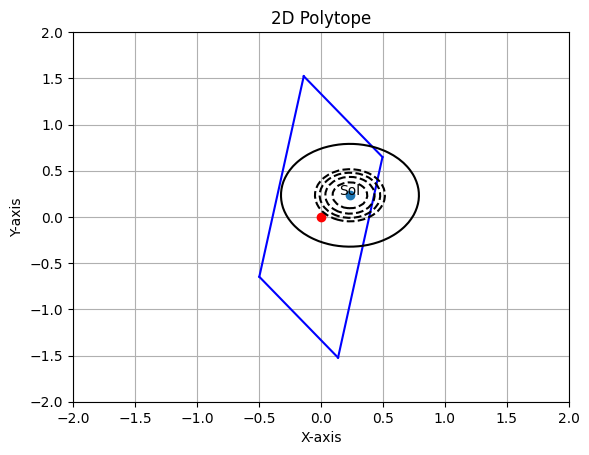

In [98]:
result = linprog(c=[0, 0], A_ub=A, b_ub=b, method='highs')
x_values, y_values = result['x']

# Plot the polytope
fig, ax = plt.subplots()
ax.plot(x_values, y_values, 'ro')  # Plot vertices as red dots

for i in range(len(A)):
    j = (i + 1) % len(A)
    ax.plot([A[i, 0], A[j, 0]], [A[i, 1], A[j, 1]], 'b-')

x_ = np.linspace(-2, 2, 100)
y_ = np.linspace(-2, 2, 100)

Z = np.zeros((len(x_), len(y_)))
for i in range(100):
    for j in range(100):
        Z[i,j] = f_plot2d(x_[i],y_[j],Q,p,A,b,t = 100000000)

alpha_levels = [vf @ Q @ vf + p @ vf + k * 1e-2 for k in range(1, 5)]  # Example alpha levels
alpha_levels.append(.1)
contour = plt.contour(x_, y_, Z, levels=alpha_levels, colors='k')
#plt.clabel(contour, inline=True, fontsize=8)


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
#ax.set_xlim(-1, 1)
#ax.set_ylim(0.2, 0.25)
plt.title('2D Polytope')
plt.scatter(optimals[-1][0], optimals[-1][1])
plt.annotate('Sol', (optimals[-1][0], optimals[-1][1]), ha='center')
plt.grid(True)
plt.show()

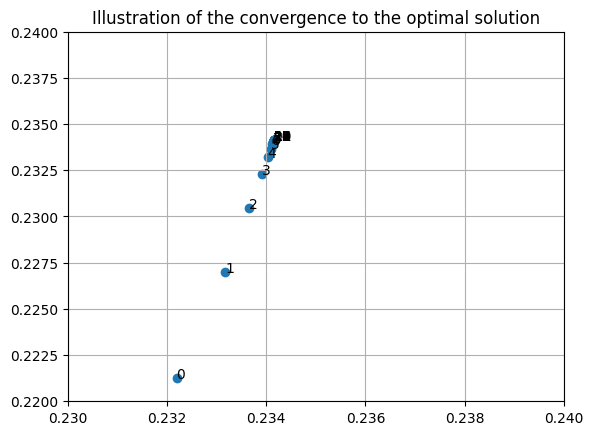

In [99]:
result = linprog(c=[0, 0], A_ub=A, b_ub=b, method='highs')
x_values, y_values = result['x']

fig, ax = plt.subplots()
ax.plot(x_values, y_values, 'ro')  # Plot vertices as red dots

for i in range(len(A)):
    j = (i + 1) % len(A)
    ax.plot([A[i, 0], A[j, 0]], [A[i, 1], A[j, 1]], 'b-')

ax.set_xlim(0.23, 0.24)
ax.set_ylim(0.22, 0.24)
plt.title('Illustration of the convergence to the optimal solution')
plt.scatter([elem[0] for elem in optimals], [elem[1] for elem in optimals])
for i in range(len(optimals)):
    plt.annotate(i, (optimals[i][0], optimals[i][1]))


plt.grid(True)
plt.show()